<a href="https://colab.research.google.com/github/nnilayy/CAFA-5-Protein-Function-Prediction/blob/main/Multi_Modal_Regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the paths
image_directory = 'path/to/images'
bitmap_directory = 'path/to/bitmaps'
ship_data_path = 'path/to/ship_data.csv'

# Load ship height data
ship_data = pd.read_csv(ship_data_path)

# Define data generators
image_datagen = ImageDataGenerator(rescale=1./255)
bitmap_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory for images and bitmaps
image_generator = image_datagen.flow_from_directory(
    image_directory,
    target_size=(height, width),
    class_mode='none',  # This means no labels are returned, only the images
    shuffle=False
)

bitmap_generator = bitmap_datagen.flow_from_directory(
    bitmap_directory,
    target_size=(height, width),
    class_mode='none',
    shuffle=False
)

# Combine image and bitmap generators and ship height data
combined_generator = zip(image_generator, bitmap_generator, ship_data['ship_height'])

# Function to preprocess the combined data
def preprocess_data(image, bitmap, ship_height):
    # Additional preprocessing can be added here if needed
    return {
        'input_rgb': image,
        'input_bitmap': bitmap,
        'input_ship_height': np.array(ship_height)
    }, np.array(ship_height)  # Assuming the target is the ship height for regression

# Apply preprocessing function to the combined generator
preprocessed_data = [preprocess_data(image, bitmap, ship_height) for (image, bitmap), ship_height in combined_generator]

# Separate the preprocessed data into inputs and targets
inputs = {
    'input_rgb': np.array([data[0]['input_rgb'] for data in preprocessed_data]),
    'input_bitmap': np.array([data[0]['input_bitmap'] for data in preprocessed_data]),
    'input_ship_height': np.array([data[0]['input_ship_height'] for data in preprocessed_data])
}

targets = np.array([data[1] for data in preprocessed_data])




In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Model architecture
height = 720
width = 480
channels = 3
input_rgb = Input(shape=(height, width, channels), name='original_image')
input_bitmap = Input(shape=(height, width, 1), name='bitmap')  # Assuming grayscale bitmap
input_ship_height = Input(shape=(1,), name='ship_height')

# RGB image processing branch
rgb_branch = Conv2D(32, (3, 3), activation='relu', padding='same')(input_rgb)
rgb_branch = MaxPooling2D((2, 2))(rgb_branch)
rgb_branch = Conv2D(64, (3, 3), activation='relu', padding='same')(rgb_branch)
rgb_branch = MaxPooling2D((2, 2))(rgb_branch)
rgb_branch = Flatten()(rgb_branch)

# Bitmap processing branch
bitmap_branch = Conv2D(32, (3, 3), activation='relu', padding='same')(input_bitmap)
bitmap_branch = MaxPooling2D((2, 2))(bitmap_branch)
bitmap_branch = Conv2D(64, (3, 3), activation='relu', padding='same')(bitmap_branch)
bitmap_branch = MaxPooling2D((2, 2))(bitmap_branch)
bitmap_branch = Flatten()(bitmap_branch)

# Concatenate the outputs of all branches and the ship height input
merged = Concatenate()([rgb_branch, bitmap_branch, input_ship_height])

# Additional layers for processing
merged = Dense(256, activation='relu')(merged)
merged = Dense(128, activation='relu')(merged)
output_distance = Dense(1, activation='linear', name='output_distance')(merged)  # Linear activation for regression

# Create the model
model = Model(inputs=[input_rgb, input_bitmap, input_ship_height], outputs=output_distance)

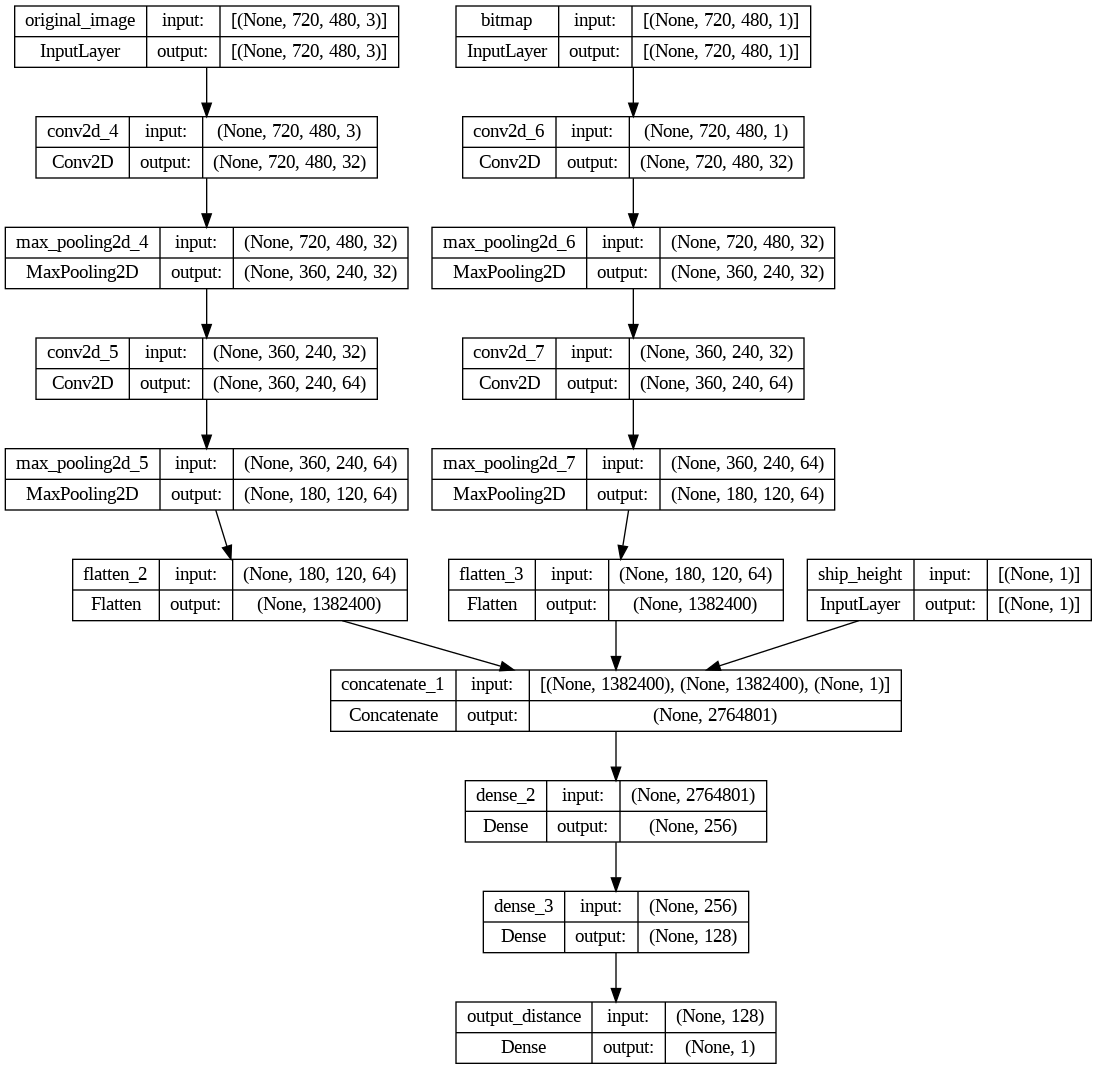

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)